# Visualizing gpx data

## Imports

In [1]:
from math import sqrt, floor

import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd
import haversine

# https://github.com/christopherbronner/gps-run-tracker/blob/master/GPS%20tracker.ipynb
import gpxpy
import gpxpy.gpx
from time import strftime
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain # import color map
from matplotlib.cm import cool # import color map

from geopy import distance as gpyd
from geographiclib.geodesic import Geodesic #for heading
geod = Geodesic.WGS84  # define the WGS84 ellipsoid
# from GPX_reader import GPX_interpolate as gpx_interpolate #for interpolating
import gpx_interpolate

from math import degrees, cos, sin, atan2 #for bearing calculations
from scipy.signal import find_peaks #for hairpin detection

import statistics #for standard deviation of turns
import os #to get files

from scipy.signal import savgol_filter
from scipy import stats # for zscore filtering pace
import seaborn as sns # seaborn for plotting

### Pull in the gps data

In [2]:
def gpxfile_to_lat_lon(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)

    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele, gpx
#     files.append(filename)
#         courses.append(os.path.splitext(base)[0])

In [3]:
def gpxfile_to_gpx(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    return gpx

In [4]:
def gpx_to_lat_lon(gpx):
    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele

In [5]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'Lat': [],'Lon': [],'Elevation': []}
    df = pd.DataFrame(df_dict)
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
                df = df.append(df_newRow, ignore_index=True)
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'])
    # Create additional column for accumulative distance
    df = add_distance(df)
    
    alt_dif = [0]
    time_dif = [0]
########################################
    #adding alt and time
    data = run_data.tracks[0].segments[0].points
    for index in range(len(data)):
        if index == 0:
            pass
        else:
            start = data[index-1]
            stop = data[index]

            alt_d = start.elevation - stop.elevation
            alt_dif.append(alt_d)

            try:
                time_delta = (stop.time - start.time).total_seconds()
            except:
                #no time in data
                time_delta = 0

            time_dif.append(time_delta)

    df1 = pd.DataFrame()
    df1['alt_dif'] = alt_dif
    df1['time_dif'] = time_dif

    print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')
    df = pd.concat([df, df1], axis=1)
########################################

    return df

# path_bayfront = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/Bayfront Park 7km.gpx'
# df = load_run_to_df(path_bayfront)
# df.head()

# # Calculate total distance of this run
# total_distance = df.iloc[-1]['Distance']    
# print('Total distance: \t%.2f km' % total_distance)

## Get the heading

In [6]:
def angle_diff(gpx_data_interp, window):
    bearing = []
    p2p_distance = []

    for i in range(len(gpx_data_interp['lon'])-1):
        lon1 = gpx_data_interp['lon'][i]
        lat1 = gpx_data_interp['lat'][i]
        lon2 = gpx_data_interp['lon'][i+1]
        lat2 = gpx_data_interp['lat'][i+1]

        bearing_tmp = atan2(sin(lon2-lon1)*cos(lat2), cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
        bearing_tmp = degrees(bearing_tmp)
        bearing_tmp = (bearing_tmp + 360) % 360
        bearing.append(bearing_tmp)

    #     bearing.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['azi1']) #degrees clockwise from north)
        p2p_distance.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['s12']) #distance between each point in meters
    
    #smoothing the bearing since for some tracks it is messy and throws off hairpin detection
#     bearing = savgol_filter(bearing, 41, 2) # window size 51, polynomial order 2
    
    # bearing.insert(0, np.nan) #making the same length as df
    p2p_distance.insert(0, 0) #making the same length as df
    p2p_distance = np.cumsum(p2p_distance)


    bearing_diff = [bearing[i + 1] - bearing[i] for i in range(len(bearing)-1)]
    angle_diff = [(bearing_diff[i] + 180) % 360 - 180 for i in range(len(bearing)-1)]

    angle_df = pd.DataFrame(angle_diff).rolling(window=window, center=True).sum()
    angle_df = angle_df.abs() # taking the absolute value so we get all the peask

    angle_df.loc[-1] = [np.nan]
    angle_df.loc[-2] = [np.nan]

    angle_df.index = angle_df.index + 3  # shifting index
    angle_df.sort_index(inplace=True) 

    df = pd.DataFrame({'Lat':gpx_data_interp['lat'],'Lon':gpx_data_interp['lon'], 'Time':gpx_data_interp['tstamp'], 'angle_diff':angle_df[0]})
    return df, bearing

## Hairpin turn detection via bearing angle difference peak detection

In [7]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

In [8]:
def hairpin_detection(df, height, bearing, gpx_data_interp, course):
    peaks, _ = find_peaks(df['angle_diff'], height=height, prominence=50)
    print('Number of hairpins in course')
    print(len(peaks))
    
#     plot it
    fig = plt.figure(figsize=(20,8))
#     plt.rcParams.update({'font.size': 22})
    plt.plot(df['angle_diff'])
    plt.plot(bearing)
    
    plt.scatter(peaks, df['angle_diff'].iloc[peaks])
    plt.title('Bearing and Bearing Changes - ' + str(course))
    plt.show()
    
#     #plot them on the course
#     fig = plt.figure(figsize=(10,10))
#     plt.rcParams.update({'font.size': 30})
#     plt.scatter(gpx_data_interp['Lon'], gpx_data_interp['Lat'], s=5)
#     plt.scatter(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], s=100)
#     plt.title('Course Map with Hairpins - ' + str(course))
#     plt.show()
    
    # bokeh
    # Create the figure: p
    p = figure(title='Course Map with Hairpins - ' + str(course), x_axis_label='Lon', y_axis_label='Lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(gpx_data_interp['lon'], gpx_data_interp['lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    
    print('Standard Deviation')
    st_dev = statistics.stdev(df['angle_diff'].dropna())
    print(st_dev)
    print('Total Degrees Turned')
    tot_deg_turned = sum([abs(ele) for ele in df['angle_diff'].dropna()])
    print(tot_deg_turned)
    
    return st_dev, tot_deg_turned, len(peaks)

In [9]:
from scipy.signal import argrelextrema

def plot_ele_max_min(df):
    # Plot results
    fig = plt.figure(figsize=(20,8))
    plt.scatter(df['dis_hav_3d'], df['min'], c='r')
    plt.scatter(df['dis_hav_3d'], df['max'], c='g')
    plt.plot(df['dis_hav_3d'], df['Elevation'])
    plt.show()

## Calculate Course Area
Look at the total area the course covers as a comparison for how turny the course is. ie how good is the course/race director at minimizing turns (if that was a desired goal).

In [10]:
def course_area(geod, df):
    p = geod.Polygon()
    for pnt in range(len(df)):
        if pnt == 0:
            continue
        p.AddPoint(df['Lat'][pnt], df['Lon'][pnt])

    num, perim, area = p.Compute()
    print("Race Distance/area of the course are {:.3f} m / {:.1f} m^2".format(perim, area))
    return perim, area

In [11]:
def hills(df):
    n=20 # number of points to be checked before and after 
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df['Elevation'].values, np.less_equal, order=n)[0]]['Elevation']
    df['max'] = df.iloc[argrelextrema(df['Elevation'].values, np.greater_equal, order=n)[0]]['Elevation']

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()]) #index locations of the max's
    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()]) #index locations of the min's

    #min locs remove duplicates
    for i in range(len(min_locs)):
        if i == len(min_locs)-1: #skip the last one
            continue
        else:
            if min_locs[i] == min_locs[i+1]-1: #check if it is the same as the previous one
                df['min'][min_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])

    #max locs remove duplicates
    for i in range(len(max_locs)):
        if i == len(max_locs)-1: #skip the last one
            continue
        else:
            if max_locs[i] == max_locs[i+1]-1: #check if it is the same as the previous one
                df['max'][max_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(max_locs)): #loop through each max location
        if i == len(max_locs)-1: #skip the last one to avoid out of range error b/c zero index
            continue
        else:
            min_val = df['min'][min_locs[i]] #get this hill's min elevation
            max_val = df['max'][max_locs[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df['dis_hav_3d'][min_locs[i]] #get this hill's start point
            hill_end = df['dis_hav_3d'][max_locs[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
            
    plot_ele_max_min(df)
        
    return min_vals, max_vals, hill_climbs, hill_lengths, df

In [12]:
def hill_details(df, peaks, mins):
    #if the first point is a peak then set the start as the min
    if len(peaks)>0 and peaks[0]<mins[0]:
        mins = np.insert(mins, 0, 0)
        
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(peaks)): #loop through each max location
        try: #error handling for weird numbered hills
            min_val = df['Elevation'].iloc[mins[i]] #get this hill's min elevation
            max_val = df['Elevation'].iloc[peaks[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df.index[mins[i]] #get this hill's start point
            hill_end = df.index[peaks[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
        except:
            print('one hill error')
        
    return min_vals, max_vals, hill_climbs, hill_lengths

In [13]:
def positive_only(x):
    if x > 0:
        return x
    else:
        return 0
    
def myround(x, prec=1, base=0.5):
    return round(base * round(float(x)/base),prec)

In [14]:
def hills_peaks(df, prominence, distance, course):
    peaks, _ = find_peaks(df['Elevation'], prominence=prominence, distance=distance)
    mins, _ = find_peaks(-df['Elevation'], prominence=prominence, distance=distance)

#     plot it
    fig = plt.figure(figsize=(20,8))
#     plt.rcParams.update({'font.size': 22})
    plt.plot(df['Elevation'])
    plt.scatter(df.index[peaks], df['Elevation'].iloc[peaks], color='red')
    plt.scatter(df.index[mins], df['Elevation'].iloc[mins], color='blue')
    plt.title('Elevation and Peaks - ' + str(course))
    plt.show()
    
    #plot them on the course
    # bokeh
    p = figure(title='Course Map with Hill Peaks - ' + str(course), x_axis_label='Lon', y_axis_label='Lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(df['Lon'], df['Lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    p.circle(df['Lon'].iloc[mins], df['Lat'].iloc[mins], color='blue', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    st_dev = statistics.stdev(df['Elevation'].dropna())
    
    pos_only = list(map(positive_only, df['alt_dif']))
    tot_elev_gain = sum(list(map(lambda x: myround(x, prec=1, base=0.9) , pos_only)))
    tot_elev_gain_unfiltered = sum(pos_only)
    
    return st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered

In [15]:
def add_distance(df):
    tmp = [0]
#     for i, row in df[1:].iterrows():
    for i, item in enumerate(df.index):
        prevCoord = (df.iloc[i-1]['Lat'],df.iloc[i-1]['Lon'])
        currCoord = (df.iloc[i]['Lat'],df.iloc[i]['Lon'])
        tmp.append(tmp[-1] + gpyd.geodesic(prevCoord, currCoord).km)
    df['Distance']=tmp[1:]
    return df

# Need to fix pace, right now it's zeros

In [51]:
# Calculate current pace
def add_pace(df):
    # pace_hist is a list of paces between two points each
#     pace_hist=[]
#     for i, row in df[1:].iterrows():
#     for i, item in enumerate(df.index):
# #         time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
# #         pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
#         pos_diff = df.index[i]-df.index[i-1]
# #         curr_pace = time_diff.seconds / pos_diff
#     df['distanceChangeInKM'] = pos_diff
#         curr_pace = df['time_dif'].iloc[i]/pos_diff
#         pace_hist.append(curr_pace/60)
    pace_hist = ((df['time_dif']/60)/df['DistanceChangeInKM']).values
    df['PaceInMinPerKM'] = pace_hist
    
    #drop when distance change is zero for unknown reasons
    df = df[df['DistanceChangeInKM']!=0] 

    # remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
    spike_tolerance = 1.3
    pace_hist_nospikes = copy.copy(pace_hist)
    for i in range(len(pace_hist_nospikes)):
        if i>1 and i<(len(pace_hist_nospikes)-2):
            if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
                pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])


    # running average of pace (without spikes), N is width of average    
    N = 23 # N must be 2n+1
    pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
    # Add Pace
    df['pace']=np.nan
    df['pace'].iloc[int((N-1)/2):-int((N-1)/2)]=pace_hist_binned
    
    #drop outlier in pace (sometimes watch seems to be stopped early or late)
    df = df.dropna()[(np.abs(stats.zscore(df['pace'].dropna())) < 3)]
    
    # Plot original pace trace in grey and spike-removed, averaged trace in red
    fig = plt.figure(figsize=(20, 8))
    #plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
#     plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r') #rolling average plot
#     plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b') #average line
    plt.plot(df.index,df['pace'],'r') #rolling average plot
    plt.title('Pace')
    plt.ylabel('pace (min per km)')
    plt.xlabel('distance (km)')
    plt.show()
    
    return df

In [17]:
def elev_map(course, df):
    fig = plt.figure(figsize=(10, 10))
    plt.title(course + ' - Elevation')
    plt.scatter(x=df['Lat'], y=df['Lon'], c=df['Elevation'], cmap=plt.cm.inferno)
    plt.ylabel('Lon')
    plt.xlabel('Lat')
    buffer = 0.0001
    plt.xlim(df['Lat'].min()-buffer, df['Lat'].max()+buffer)
    plt.ylim(df['Lon'].min()-buffer, df['Lon'].max()+buffer)

    cbar = plt.colorbar()
    cbar.set_label('Elevation (m)')

    plt.show()

In [18]:
def pace_elev_map(course, df):
    fig = plt.figure(figsize=(10, 10))
    plt.title(course + ' - Elevation and Pace')
    # sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = scaler.transform(df[['Elevation']])*50)
    h_min = df['Elevation'].min()
    h_const = 10 #constant to adjust the heights
    f = lambda a: a-h_min+h_const 
    g = lambda s: s+h_min-h_const
    sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = f(df[['Elevation']].values))
    # sc = plt.scatter(x=df['Lat'], y=df['Lon'], c=df['pace'], cmap=plt.cm.inferno, s = df['Elevation'])
    plt.ylabel('Lon')
    plt.xlabel('Lat')
    buffer = 0.0001
    plt.xlim(df['Lat'].min()-buffer, df['Lat'].max()+buffer)
    plt.ylim(df['Lon'].min()-buffer, df['Lon'].max()+buffer)
    cbar = plt.colorbar()
    cbar.set_label('Pace (min)')

    plt.legend(*sc.legend_elements("sizes", num=5, func=g), title='Elevation (m)')

    plt.show()

In [50]:
pace_hist = ((df['time_dif']/60)/df['DistanceChangeInKM']).values
df['PaceInMinPerKM'] = pace_hist

#drop when distance change is zero for unknown reasons
df = df[df['DistanceChangeInKM']!=0] 

# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])


# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')

# Add Pace
df['pace']=np.nan
df['pace'].iloc[int((N-1)/2):-int((N-1)/2)]=pace_hist_binned

In [45]:
len(pace_hist_binned)

1441

In [46]:
len(df)

1463

In [48]:
len(df['pace'].iloc[int((N-1)/2):-int((N-1)/2)])

1441

In [49]:
df['pace'].iloc[int((N-1)/2):-int((N-1)/2)]=pace_hist_binned

/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


King City 10km.gpx
Interpolating ...
Number of hairpins in course
1


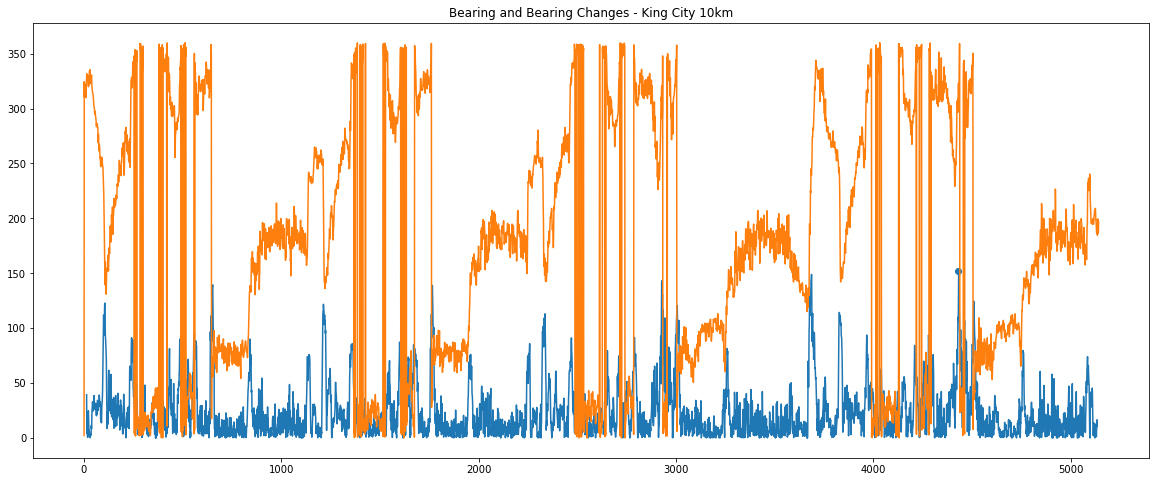

Standard Deviation
25.00802009817647
Total Degrees Turned
124457.40311915138
Race Distance/area of the course are 10365.704 m / -961627.1 m^2
Total Time :  97  min  25  sec 


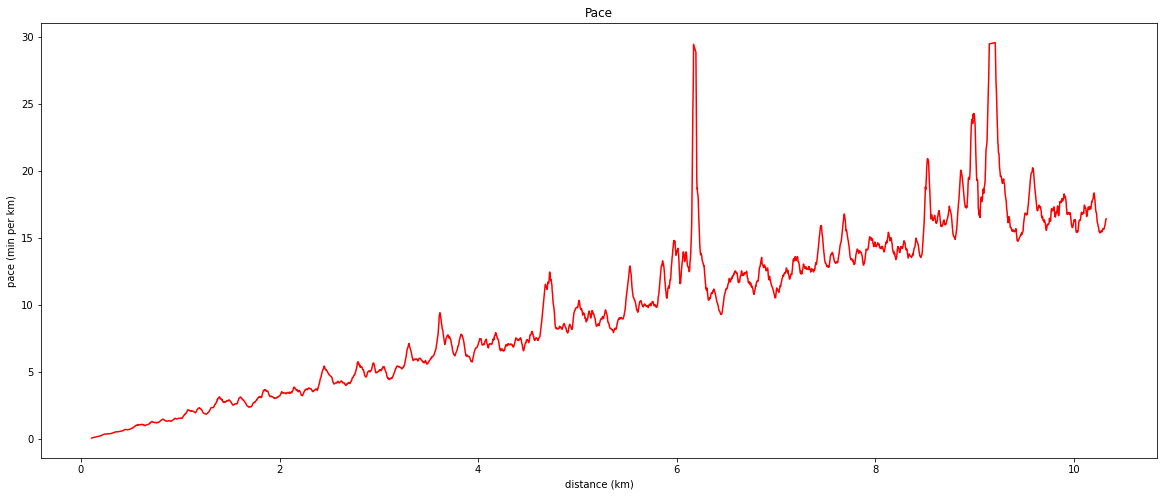

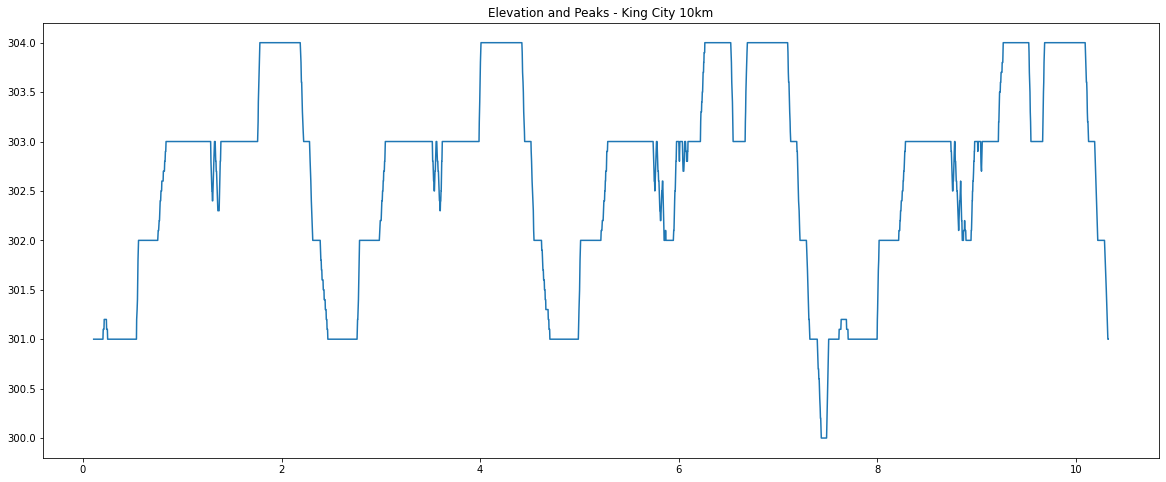

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


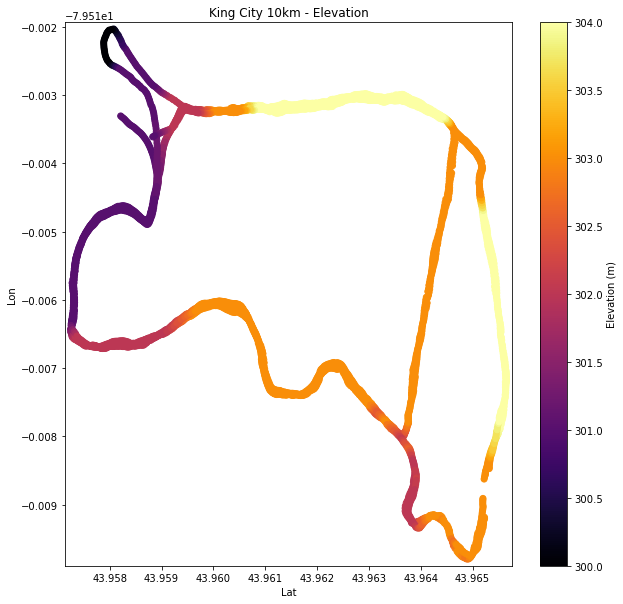

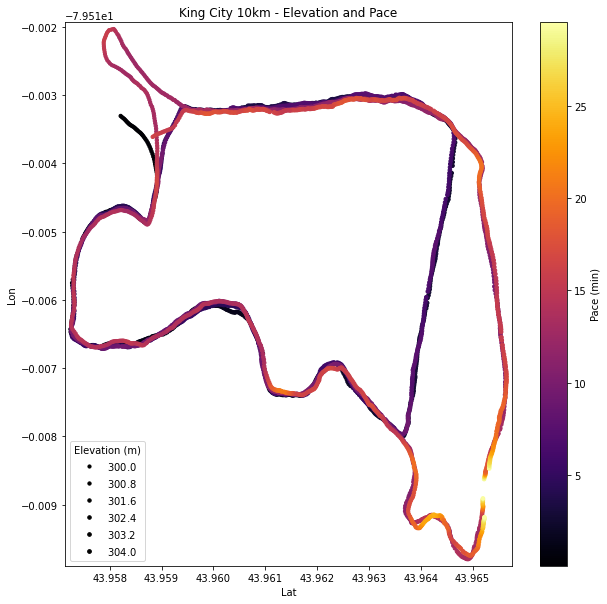

Western International 10km.gpx
Interpolating ...
Number of hairpins in course
4


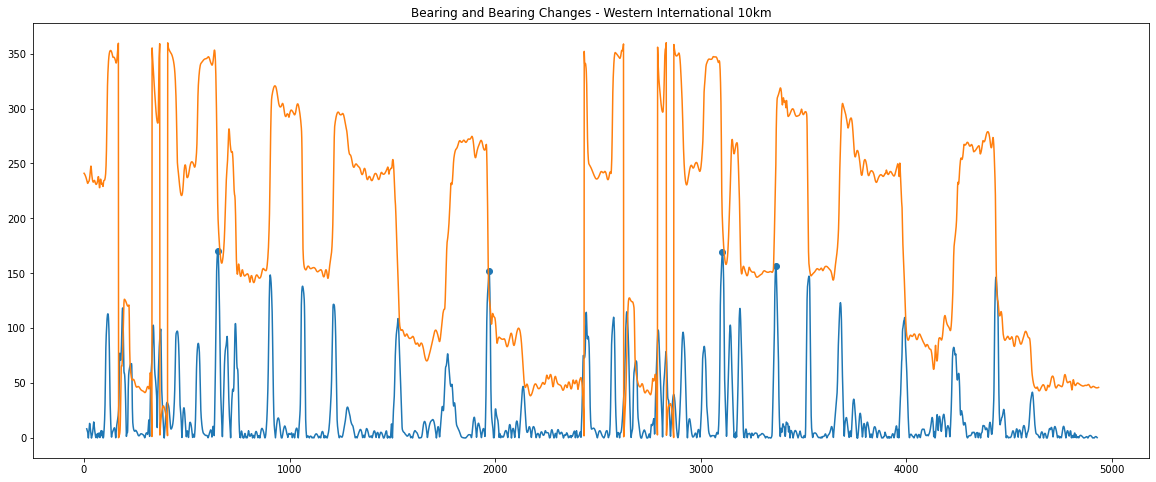

Standard Deviation
33.53918163507511
Total Degrees Turned
107063.69093055256
Race Distance/area of the course are 9995.070 m / 460585.0 m^2
Total Time :  33  min  53  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


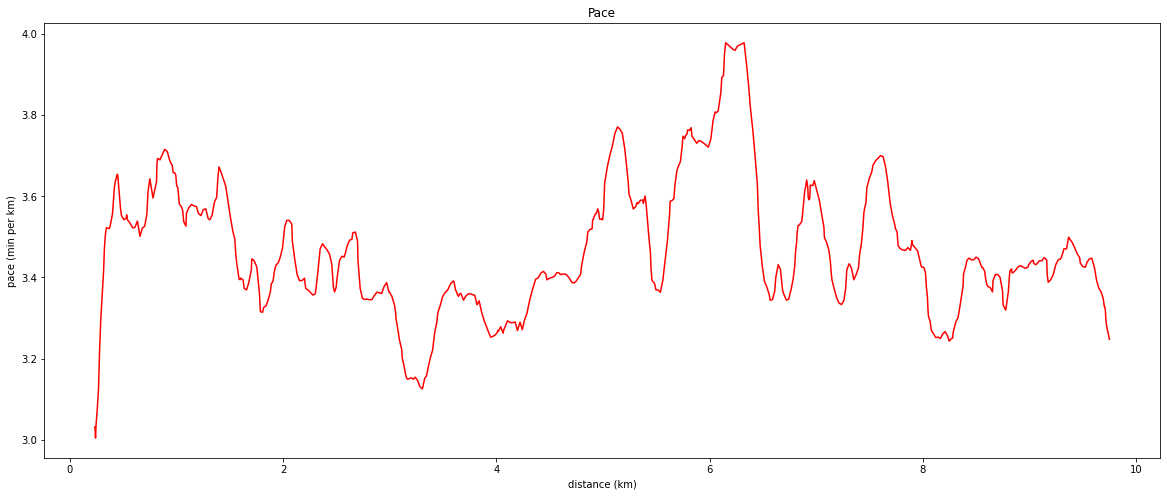

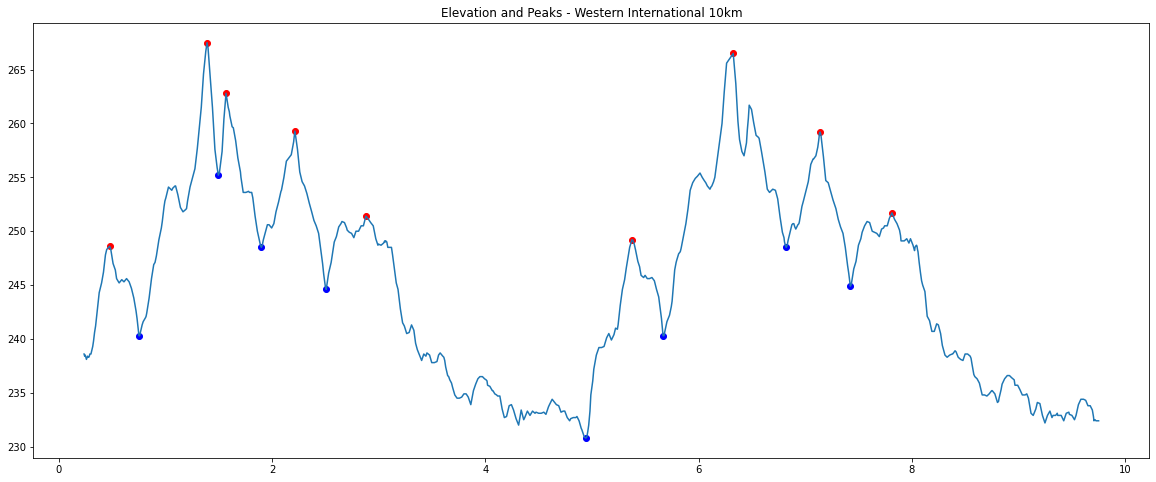

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


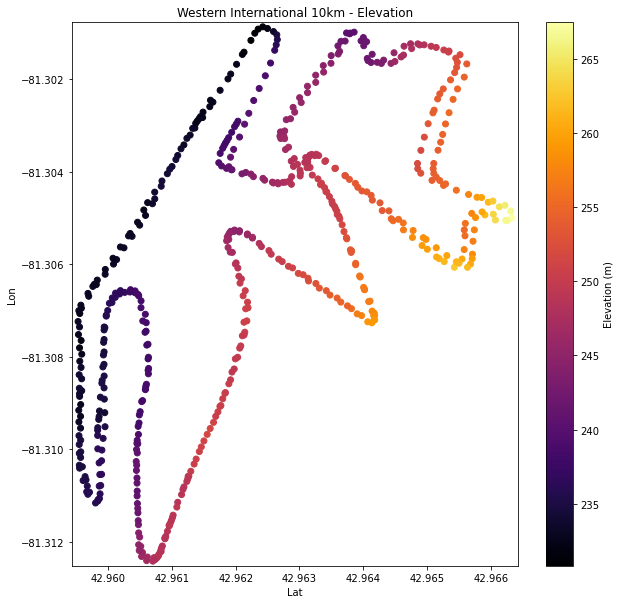

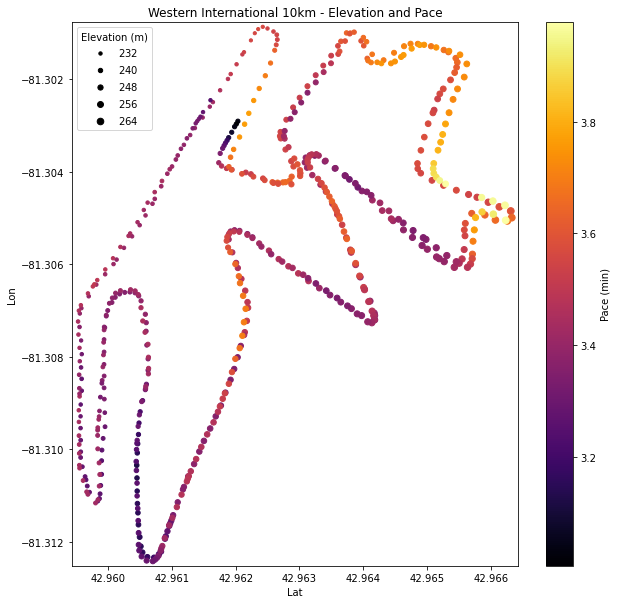

Louisville Classic 8km.gpx
Interpolating ...
Number of hairpins in course
0


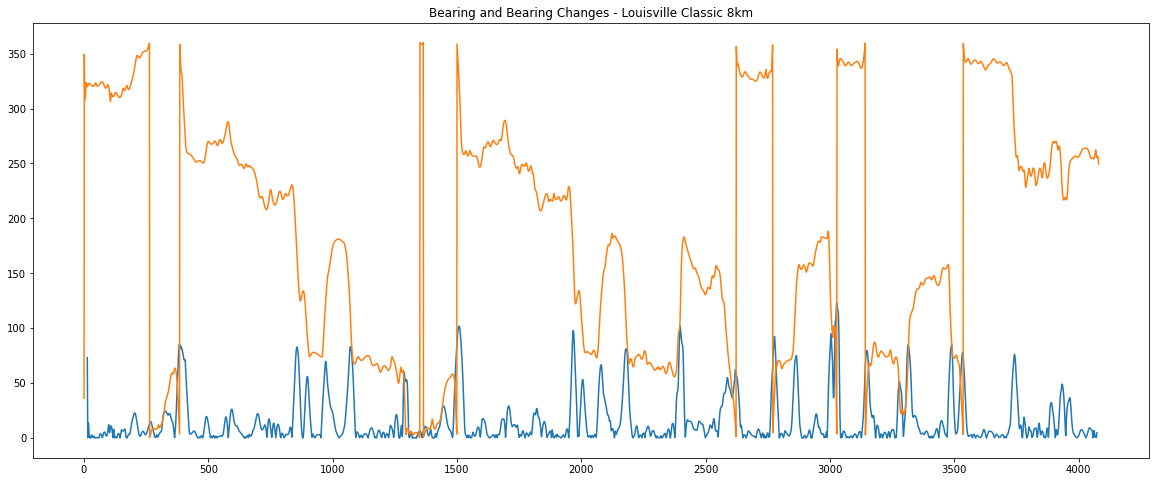

Standard Deviation
22.2837336800528
Total Degrees Turned
65813.16373870807
Race Distance/area of the course are 8564.184 m / 644055.3 m^2
Total Time :  26  min  10  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


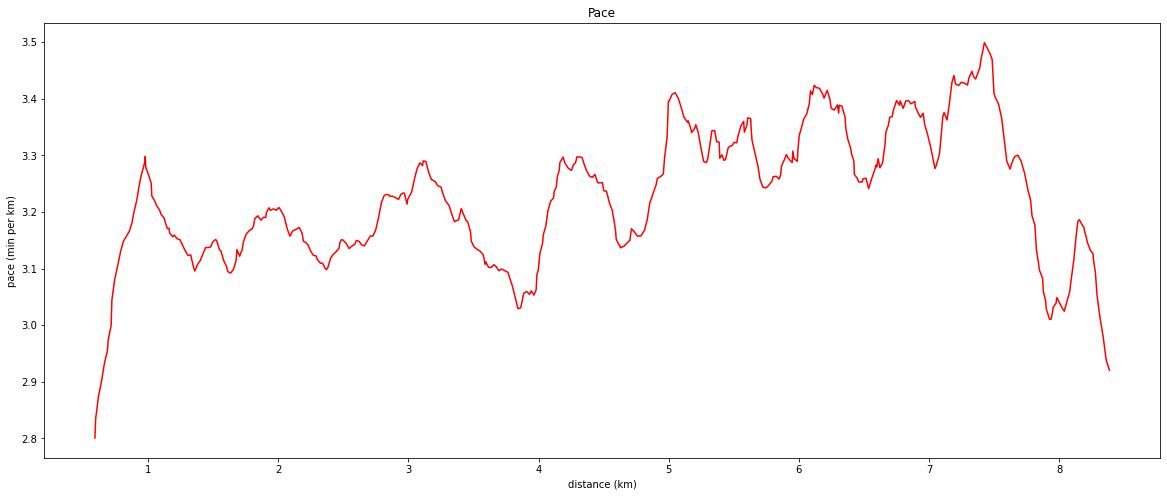

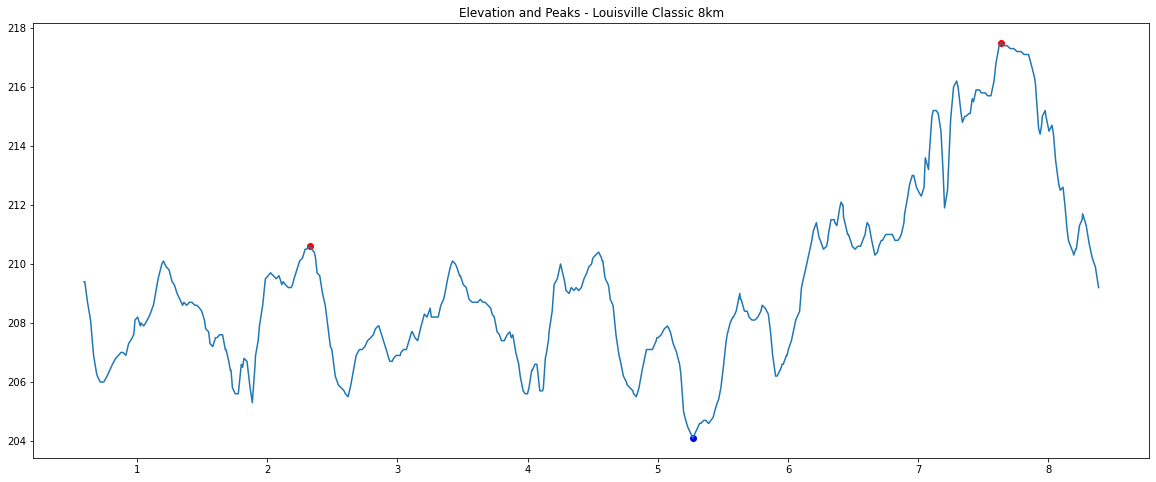

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


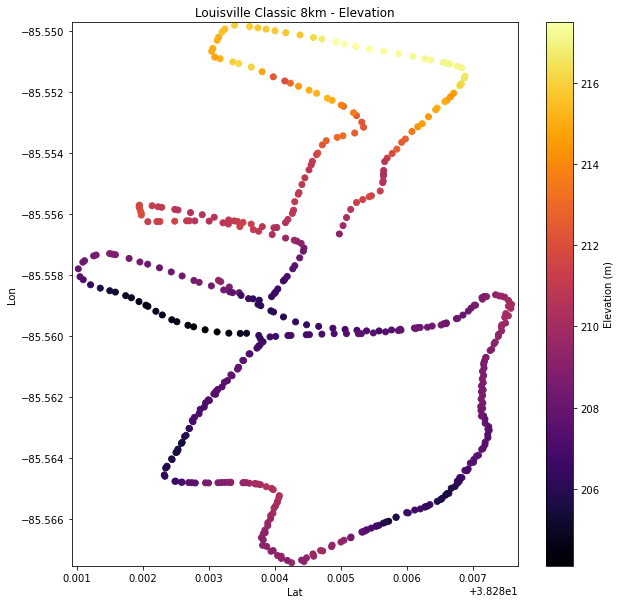

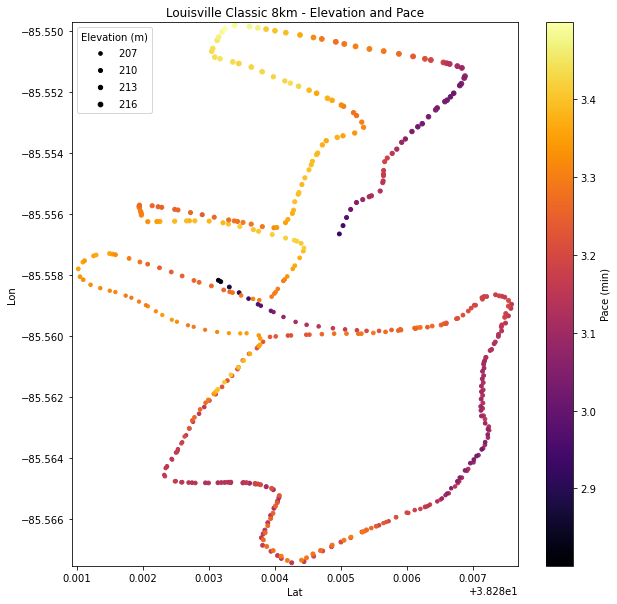

Fort Henry 10km.gpx
Interpolating ...
Number of hairpins in course
4


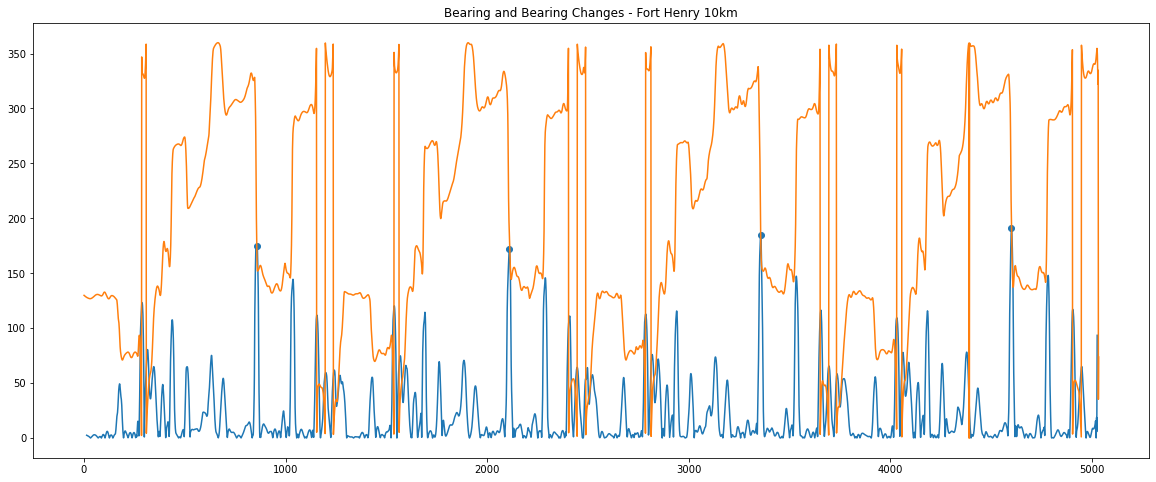

Standard Deviation
33.21071983115071
Total Degrees Turned
121117.15558384646
Race Distance/area of the course are 10146.846 m / -325336.8 m^2
Total Time :  35  min  33  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


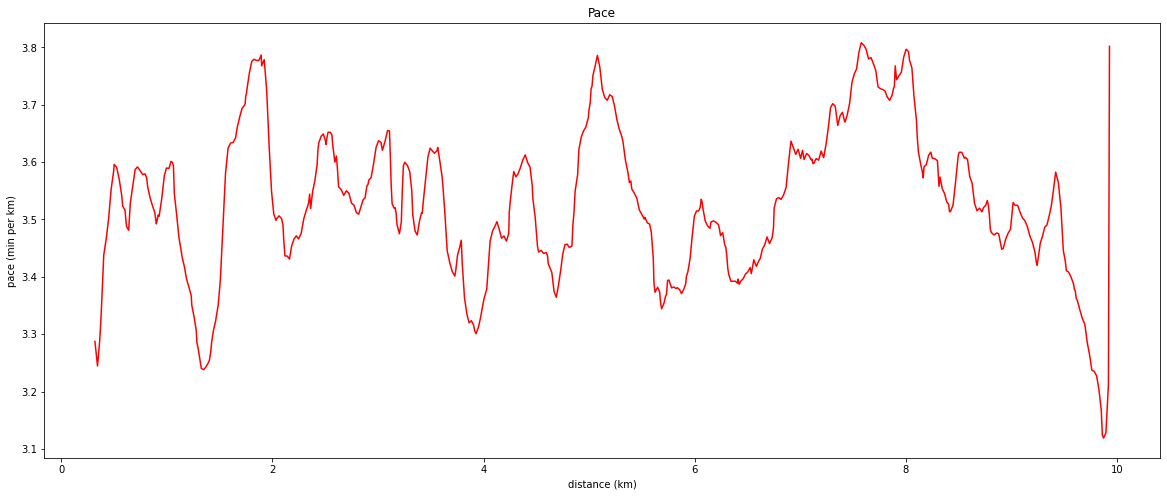

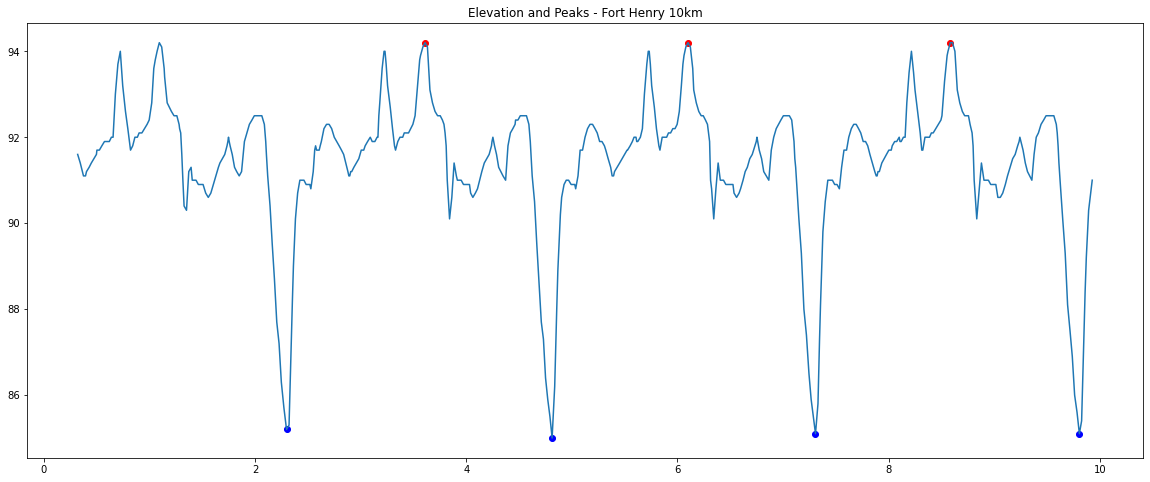

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


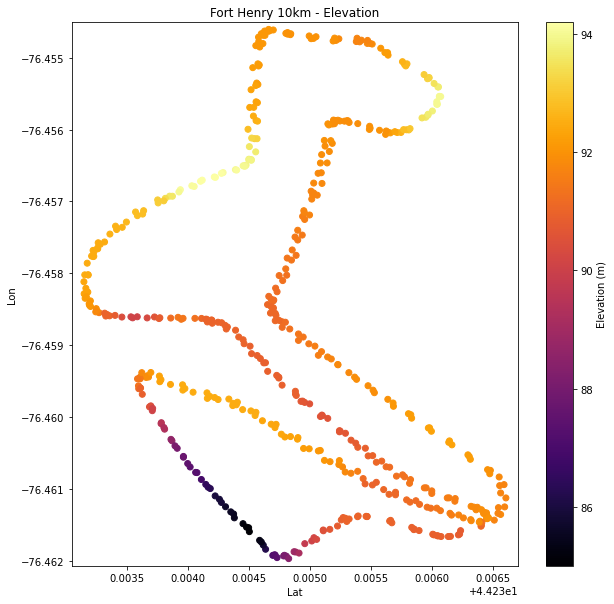

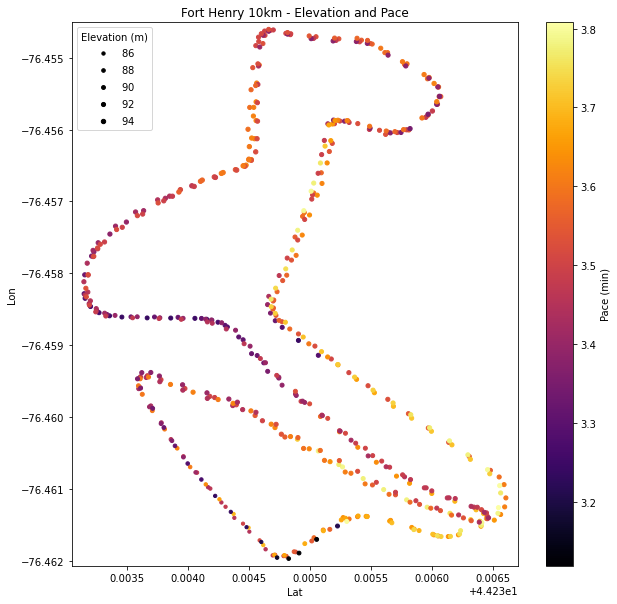

Point Pleasant Park.gpx
Interpolating ...
Number of hairpins in course
14


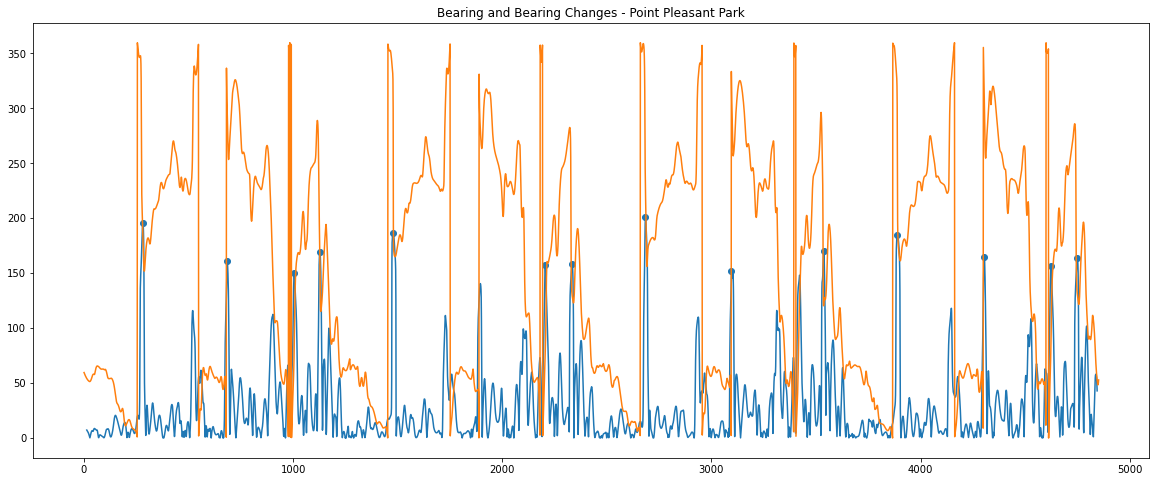

Standard Deviation
37.76421152193486
Total Degrees Turned
149565.77457126835
Race Distance/area of the course are 9833.651 m / 229523.5 m^2
Total Time :  34  min  14  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


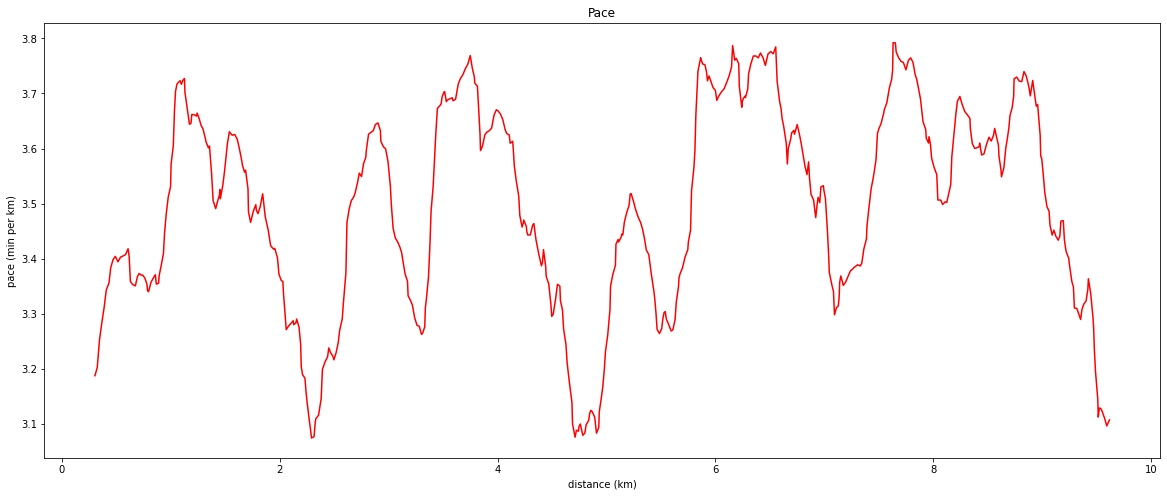

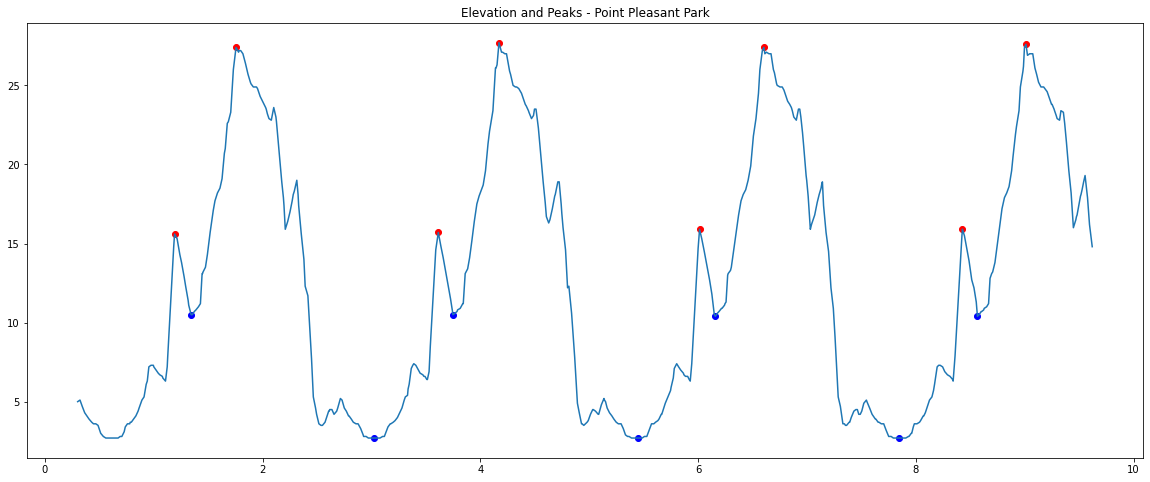

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


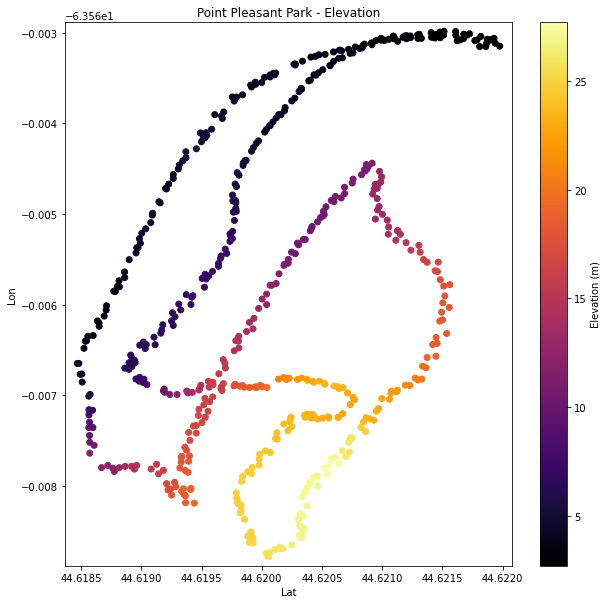

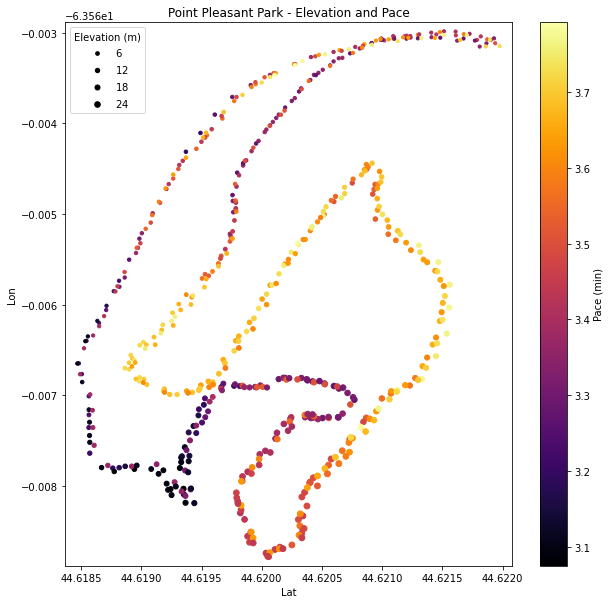

Malden Park 10km.gpx
Interpolating ...
Number of hairpins in course
9


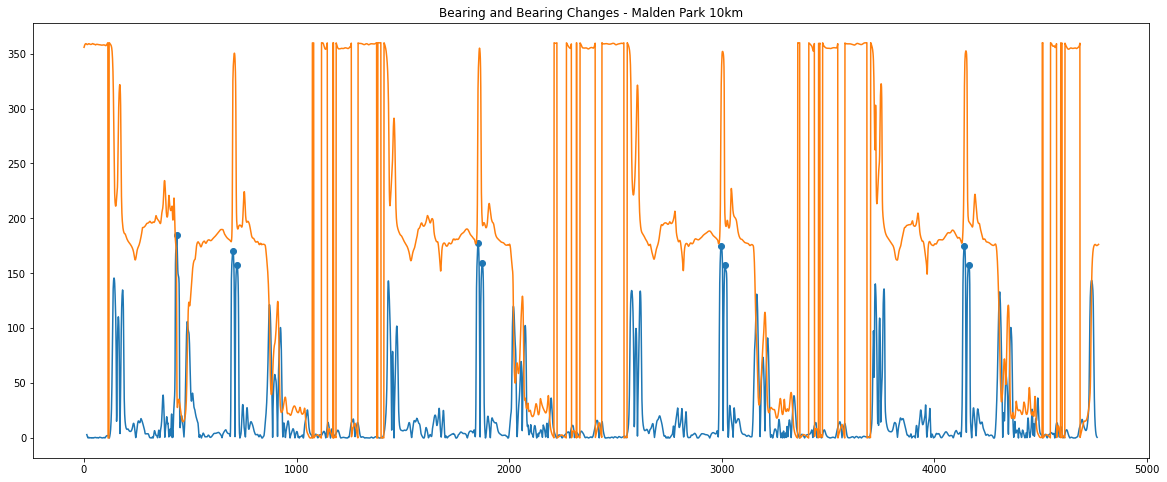

Standard Deviation
36.00910986447724
Total Degrees Turned
94586.13878299389
Race Distance/area of the course are 9676.019 m / -652511.8 m^2
Total Time :  32  min  43  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


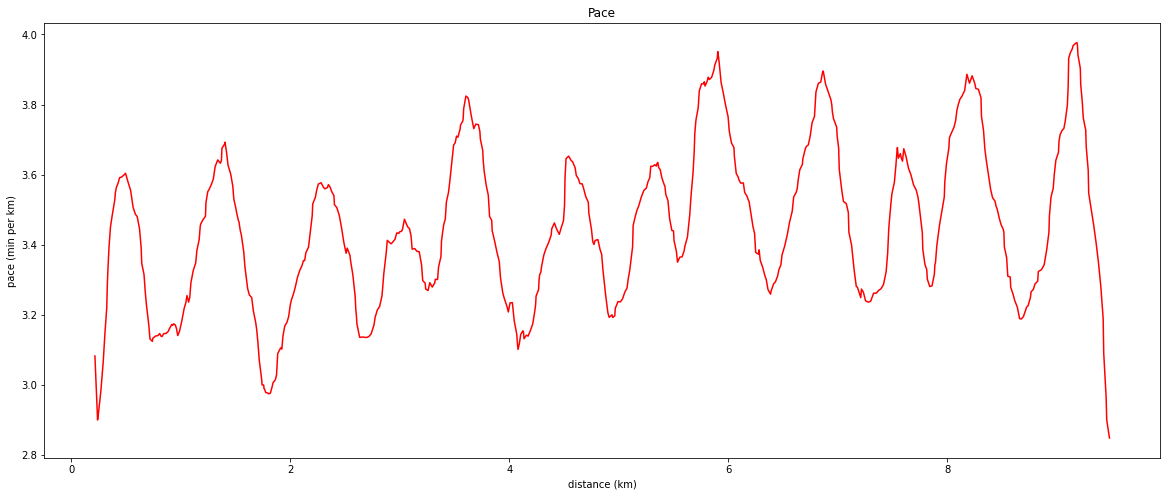

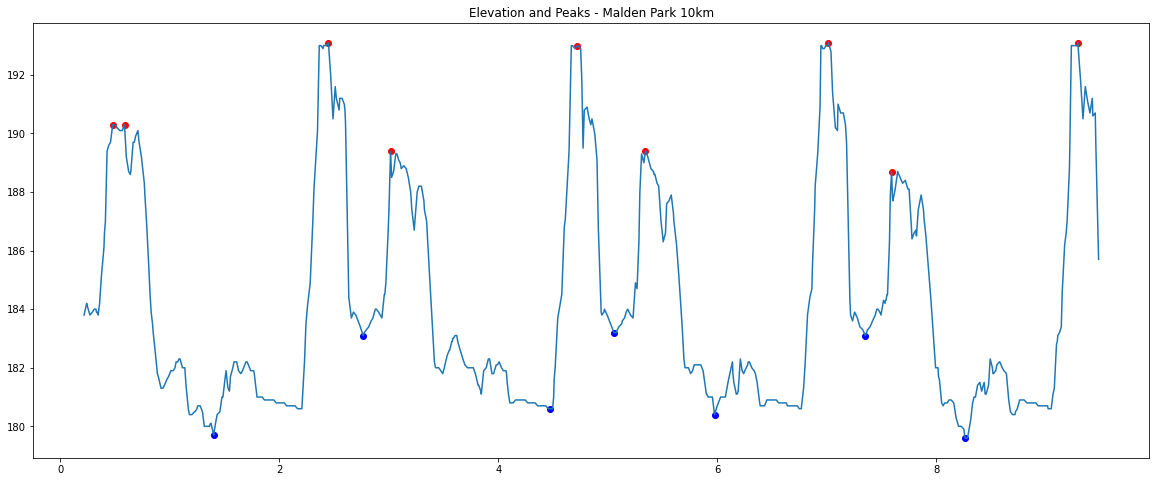

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
one hill error
hills


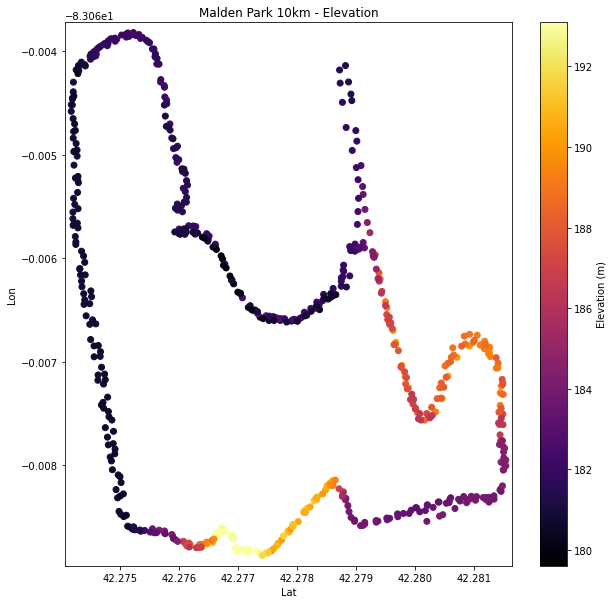

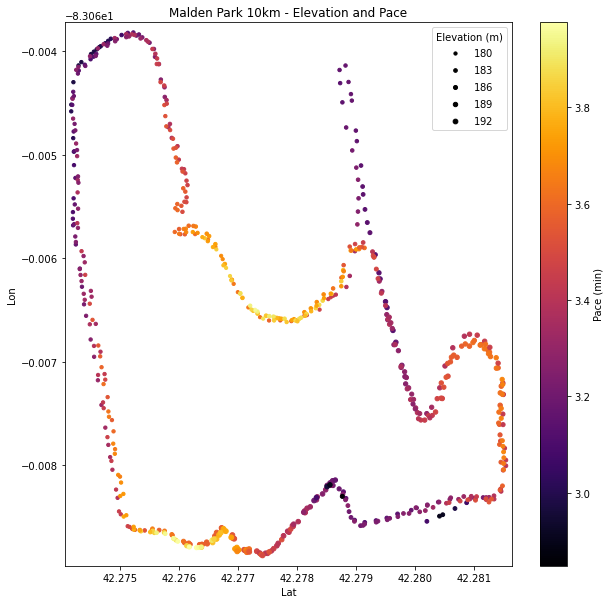

Moncton Classic 8km.gpx
Interpolating ...
Number of hairpins in course
4


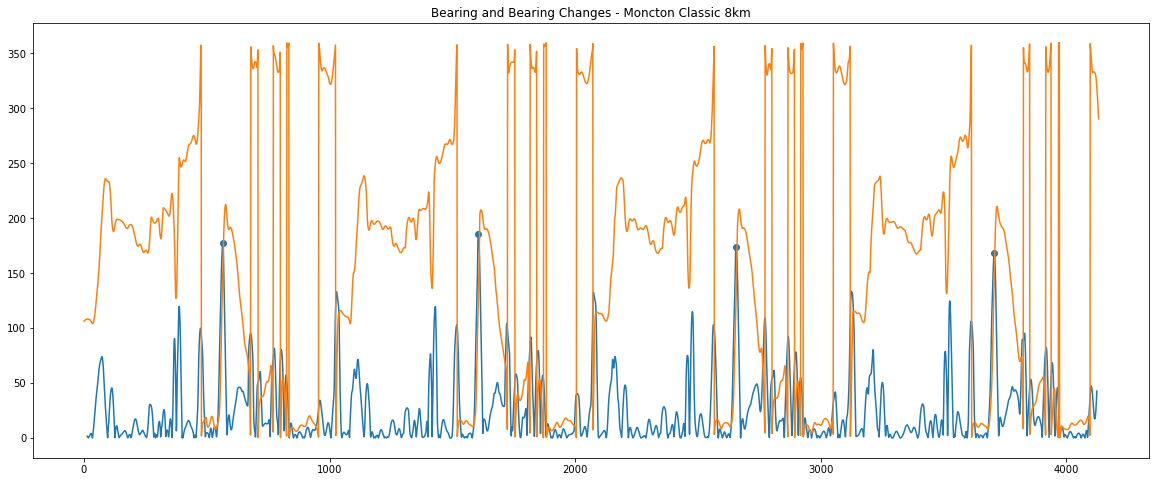

Standard Deviation
32.68980477641429
Total Degrees Turned
111237.32020398279
Race Distance/area of the course are 8364.974 m / 113177.2 m^2
Total Time :  29  min  58  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


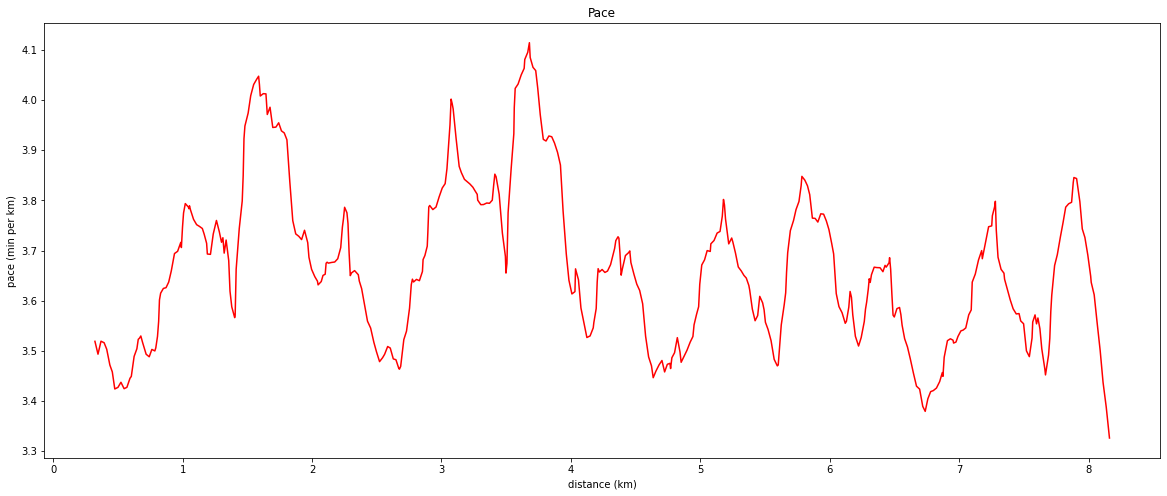

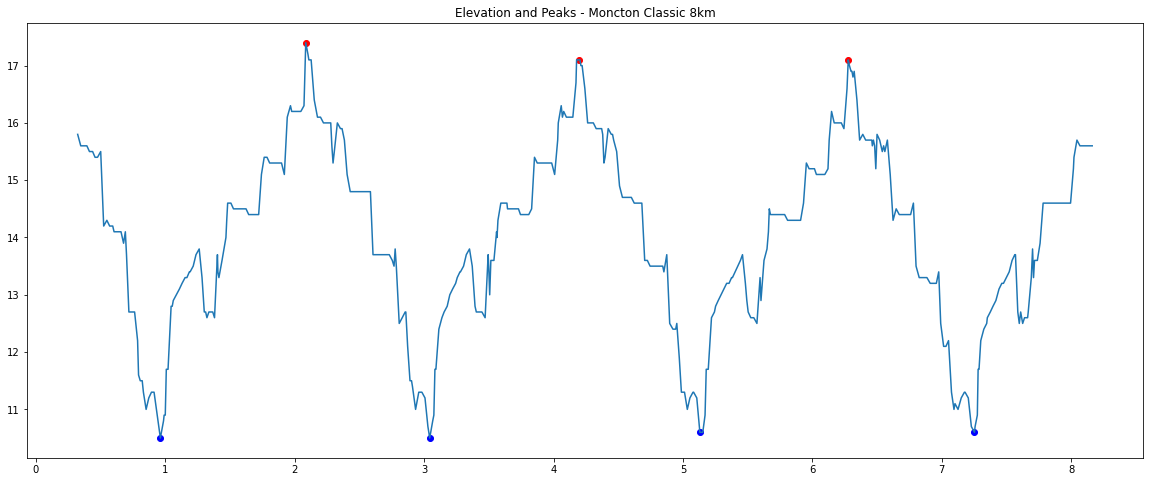

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


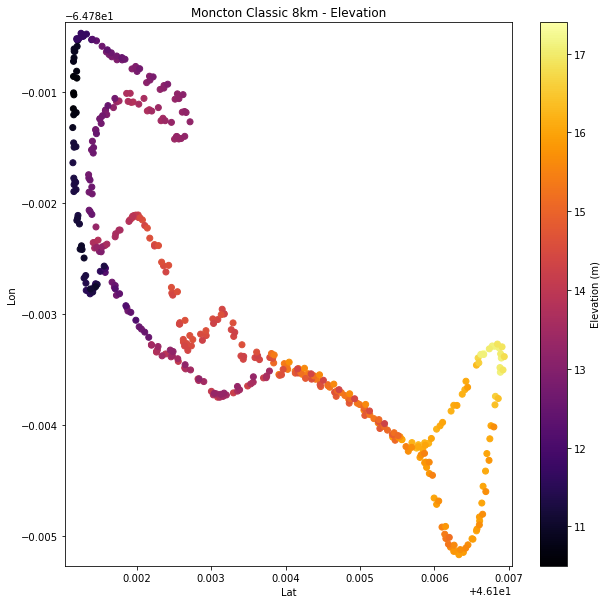

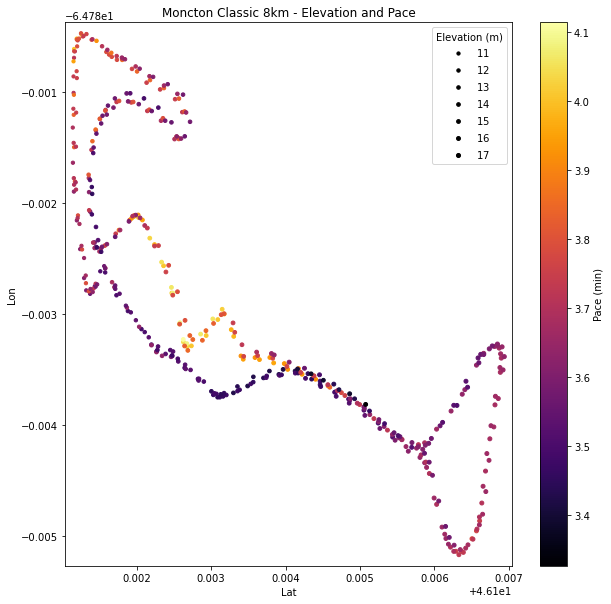

Guelph Arboretum 7_5km.gpx
Interpolating ...
Number of hairpins in course
0


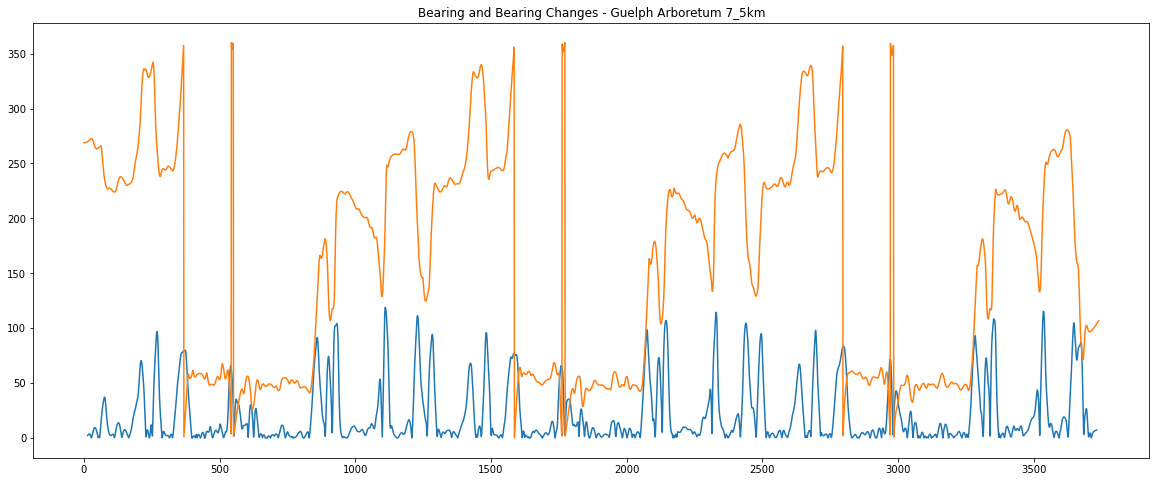

Standard Deviation
27.788016219171233
Total Degrees Turned
81815.02169035109
Race Distance/area of the course are 7567.653 m / -524346.6 m^2
Total Time :  24  min  13  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


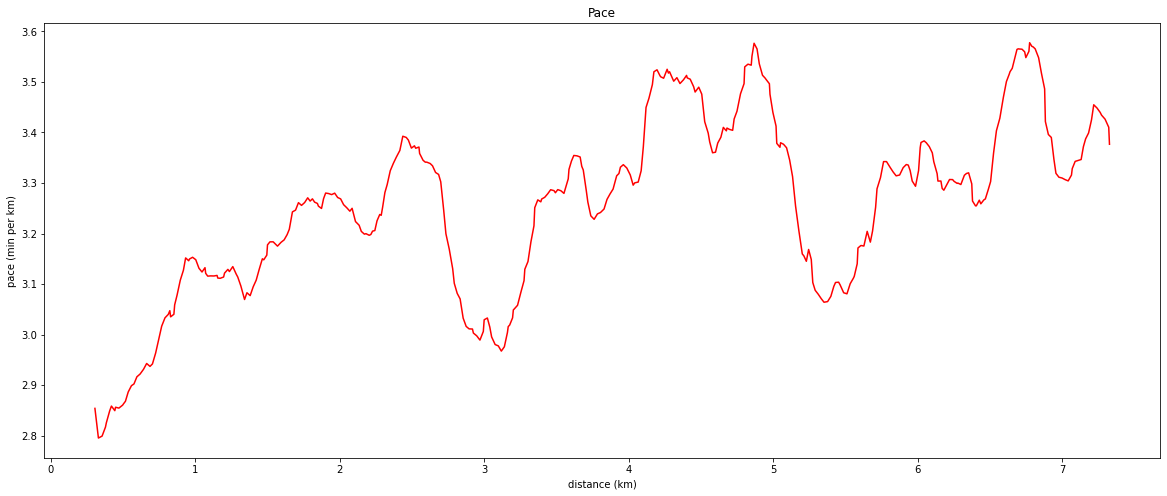

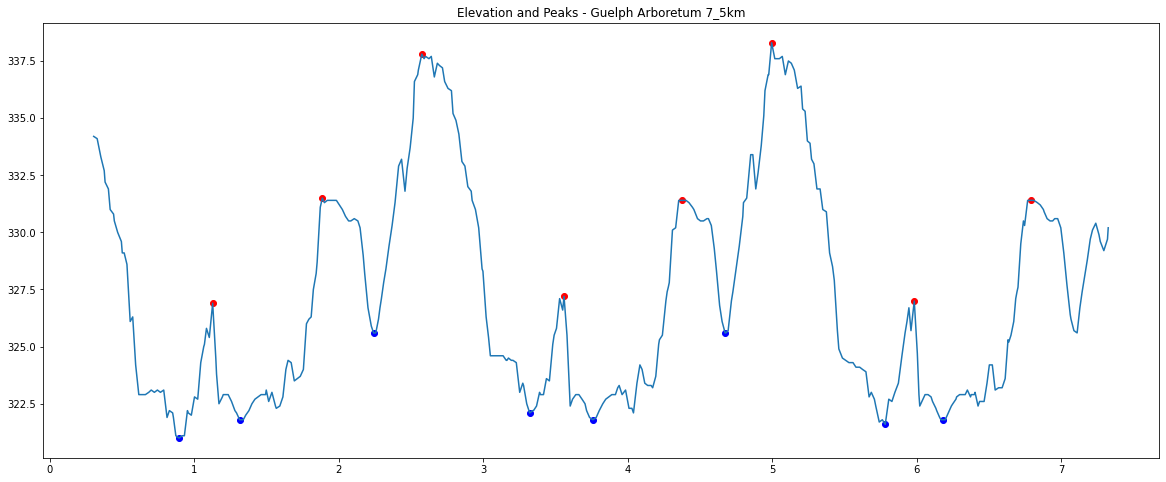

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


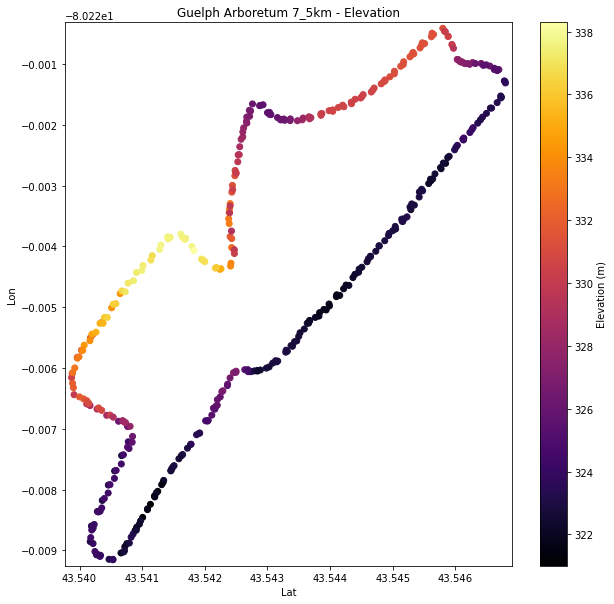

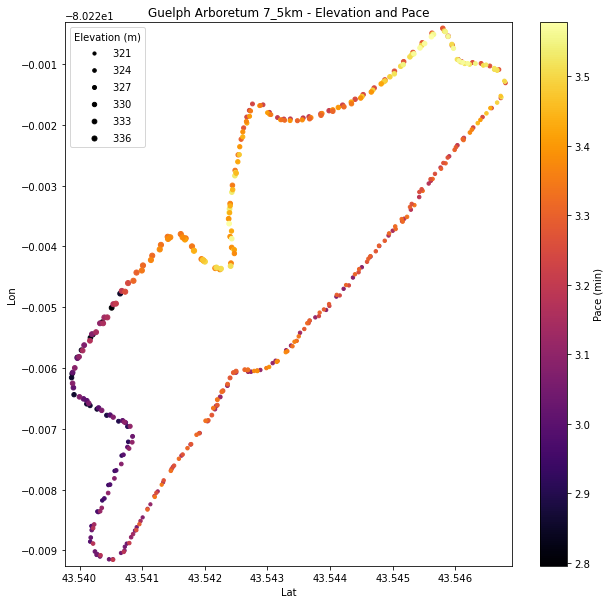

Fanshawe Invitational 8km.gpx
Interpolating ...
Number of hairpins in course
5


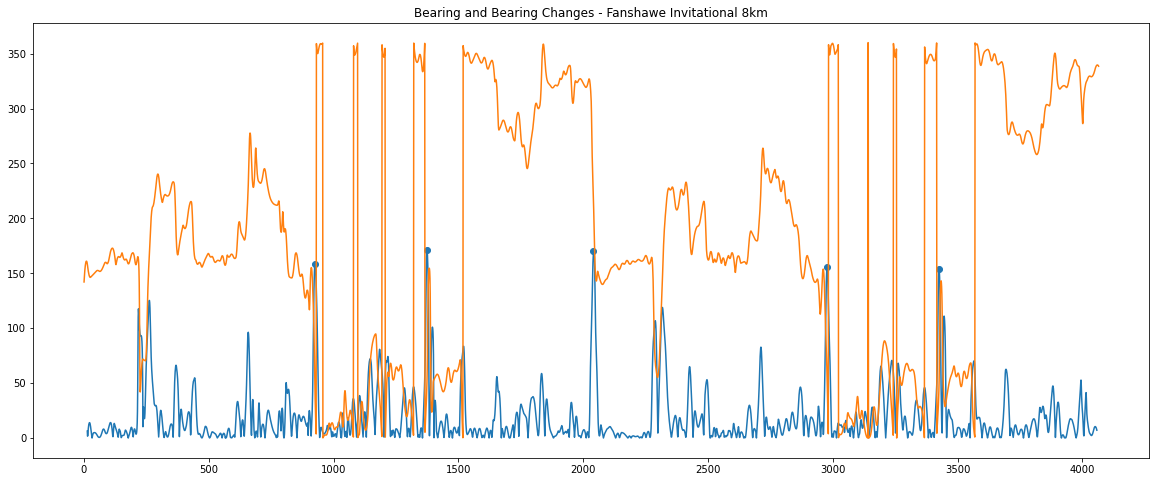

Standard Deviation
26.932202222785616
Total Degrees Turned
82266.77358453604
Race Distance/area of the course are 8189.232 m / 609485.1 m^2
Total Time :  30  min  6  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


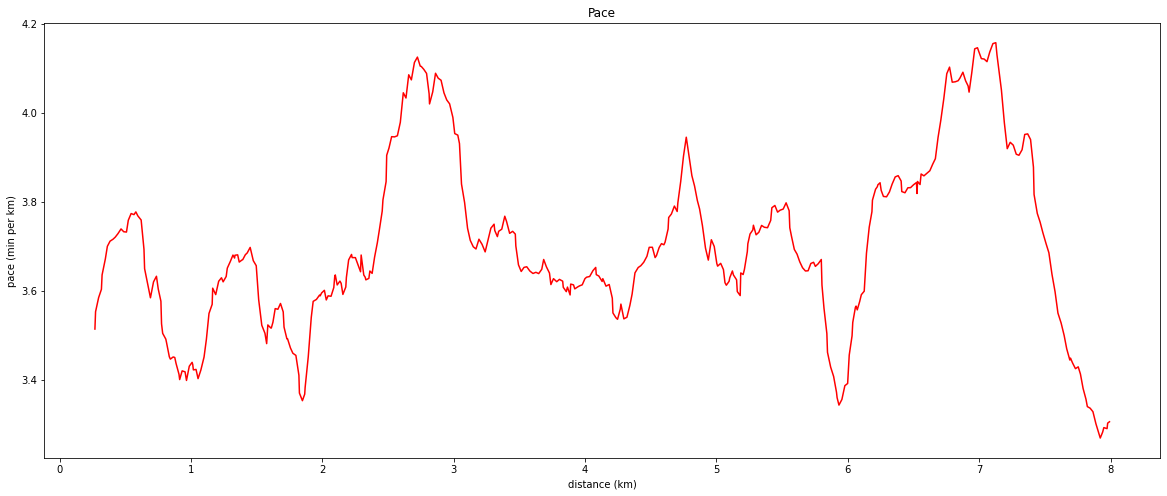

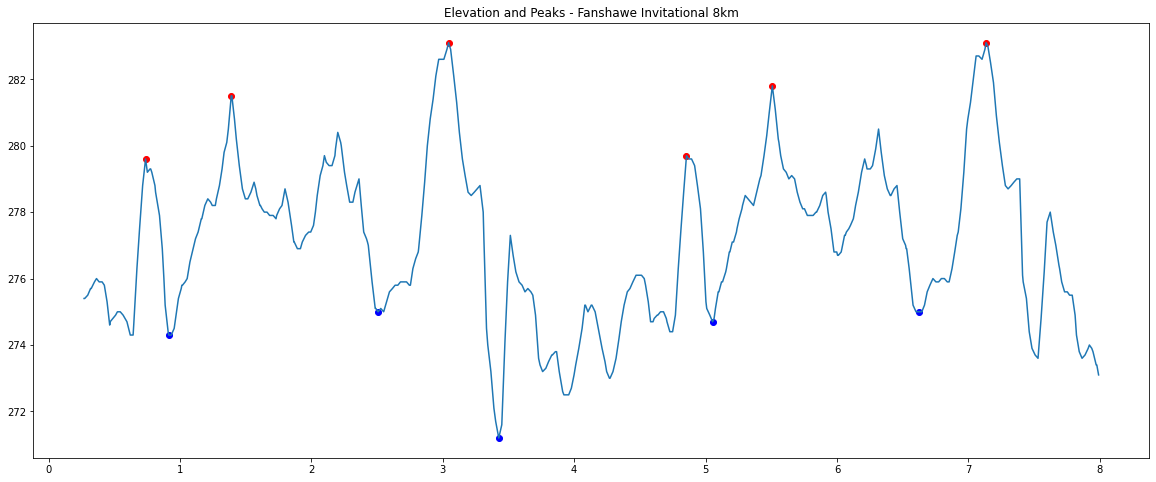

Index(['time', 'Lat', 'Lon', 'Elevation', 'alt_dif', 'time_dif',
       'DistanceChangeInKM', 'PaceInMinPerKM', 'pace'],
      dtype='object')
hills


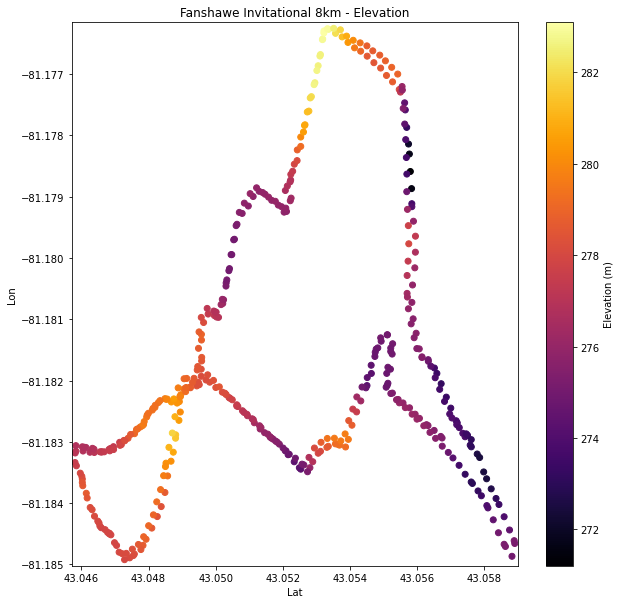

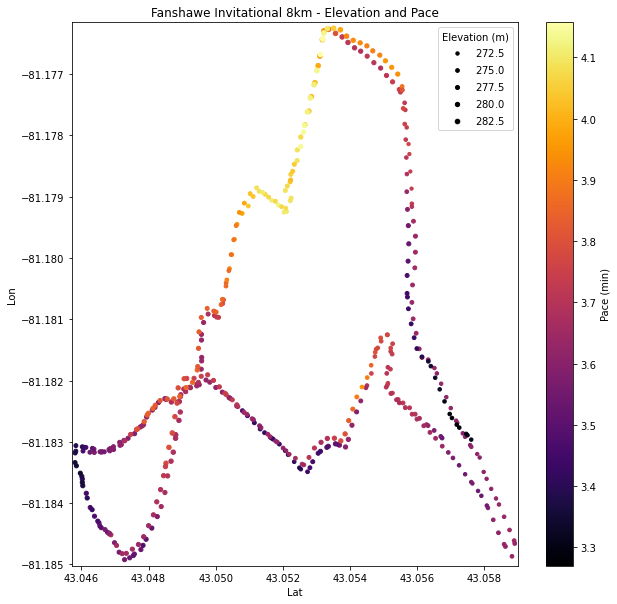

StFX Invitational 8km.gpx
Interpolating ...
Removed 198 duplicate trackpoint(s)
Number of hairpins in course
64


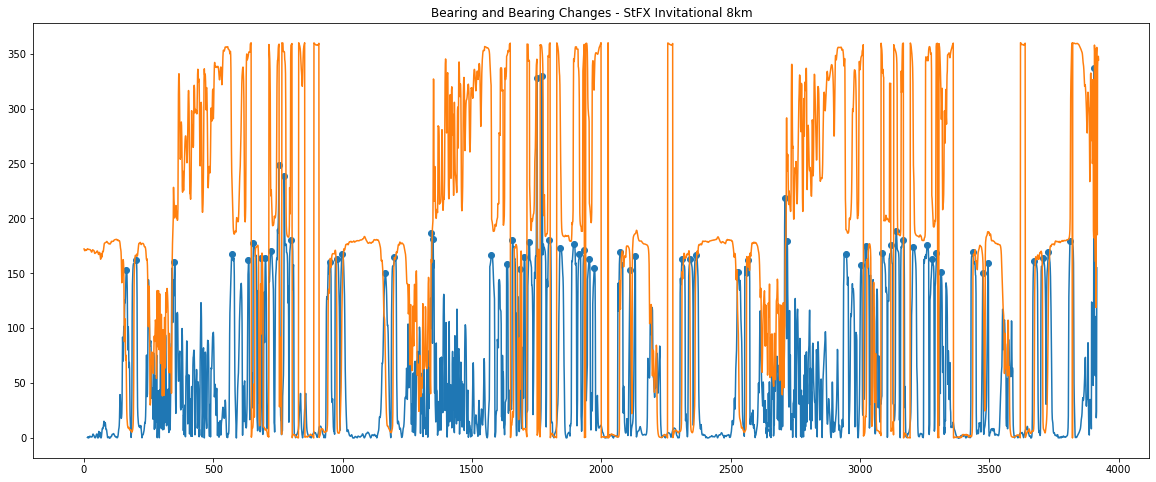

Standard Deviation
62.495828906995015
Total Degrees Turned
229882.1704813834
Race Distance/area of the course are 7877.891 m / 209506.5 m^2
Total Time :  29  min  30  sec 


/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeremywalsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


ValueError: cannot set using a slice indexer with a different length than the value

In [52]:
path = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/'
directory = os.fsencode(path)
    
courses = []
st_devs = []
tot_deg_turneds = []
perims = []
areas = []
num_hairpins = []
dfs = []
tallest_hills = []
num_hills_list = []
turn_st_devs = []
hill_st_devs = []
tot_elev_gains = []
tot_elev_gain_unfiltereds = []
hill_dfs = []
lengthoftallesthill = []
start_loc_list = []
start_lat_list = []
start_lon_list = []


for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".gpx"): 
        
        print(filename)
        
        base=os.path.basename(path + filename)
        course = os.path.splitext(base)[0]
        courses.append(course)
        
        gpx_file = path + filename
        gpx_data = gpx_interpolate.gpx_read(gpx_file)
        gpx_data_interp = gpx_interpolate.gpx_interpolate(gpx_data, res=2, deg = 3)
        
        window = 20 #meters long to consider a hairpin turn complete
        df, bearing = angle_diff(gpx_data_interp, window)
        
        height = 150 #number of degrees in a hairpin turn over the window length
        turn_st_dev, tot_deg_turned, num_peak = hairpin_detection(df, height, bearing, gpx_data_interp, course)
        
        perim, area = course_area(geod, df)
        
        turn_st_devs.append(turn_st_dev)
        tot_deg_turneds.append(tot_deg_turned)
        perims.append(perim)
        areas.append(area)
        num_hairpins.append(num_peak)
        
        #get the elevation and distance
#         gpx = gpxfile_to_gpx(path, filename)
#         lat, lon, ele = gpx_to_lat_lon(gpx)
#         df = pd.DataFrame({'Lat': lat, 'Lon': lon, 
#                    'Elevation': ele})
#         base=os.path.basename(path + filename)
#         gpx_file = open(path + filename, 'r')
        df = load_run_to_df(gpx_file)
        df['DistanceChangeInKM'] = df['Distance']-df['Distance'].shift()
        df.set_index('Distance', inplace=True)
#         df = add_alt_time_dif(gpx, df)
        df = add_pace(df)
        
         
#         course_max_min(df) #plot the course max and min
        
#         #get the hills
#         min_vals, max_vals, hill_climbs, hill_lengths, df = hills(df)
#         print('hills')
#         print(hill_climbs, hill_lengths)
        
        hill_min_height = 5
        length_of_hill = 5
        hill_st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered = hills_peaks(df, hill_min_height, length_of_hill, course)
        hill_st_devs.append(hill_st_dev)
        tot_elev_gains.append(tot_elev_gain)
        tot_elev_gain_unfiltereds.append(tot_elev_gain_unfiltered)
        
        print(df.columns)
        min_vals, max_vals, hill_climbs, hill_lengths = hill_details(df, peaks, mins)
        print('hills')
        hill_grade = np.divide(hill_climbs, hill_lengths)*100
        # put all of the hill details into a dataframe of some sort so that we can compare the different sites
        hill_df = pd.DataFrame({'Hill Height': hill_climbs, 'Hill Distance': hill_lengths, 'Hill Grade': hill_grade})
        #drop hills with too low of a grade
        hill_df.drop(hill_df[hill_df['Hill Grade'] < 1].index, inplace=True)
        hill_df.reset_index(drop=True, inplace=True)
        num_hills = len(hill_df)
        
        #list of tallest hill for each course
        tallest_hills.append(hill_df['Hill Height'].max())
        if len(hill_df)>0: #check if there are any hills
            lengthoftallesthill.append(hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'].min())
        else:
            lengthoftallesthill.append(np.nan)
        hill_dfs.append(hill_df)
        num_hills_list.append(num_hills)
        start_lat_list.append(df['Lat'].iloc[0])
        start_lon_list.append(df['Lon'].iloc[0])
        
        #Add in more columns
#         df = add_accuDist(df)
#         df = add_pace(df)
        # Couple plots
        elev_map(course, df)
        pace_elev_map(course, df)
        
        dfs.append(df)
        
course_info_df = pd.DataFrame({'Course': courses, 'Turn Stdev': turn_st_devs, 
                               'Total Degrees Turned': tot_deg_turneds, 'Perimeters/Total Distance': perims,
                              'Course Area (m^2)': areas, 'Number of Hairpin Turns': num_hairpins, 'Hill Stdev': hill_st_devs,
                              'Tallest Hill (m)': tallest_hills, 'Length of tallest hill (m)': lengthoftallesthill, 'Number of Hills': num_hills_list,
                              'Total Elevation Gain (m)': tot_elev_gains, 'Total Elevation Gain Unfiltered (m)': tot_elev_gain_unfiltereds,
                              'Start Lat': start_lat_list, 'Start Lon': start_lon_list})
course_info_df['Course Area (m^2)'] = course_info_df['Course Area (m^2)'].abs() #sometiems area is negative


In [1]:
df

NameError: name 'df' is not defined

In [ ]:
course_info_df.sort_values(by=['Total Elevation Gain (m)'], ascending=False)

In [ ]:
# Turns
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(course_info_df['Turn Stdev'], course_info_df['Total Degrees Turned'], color='red', label='Total Degrees Turned')
ax.set_ylabel('Degrees Turned', color='red')
ax.set_xlabel('Turn Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Turn Stdev'], course_info_df['Course Area (m^2)'], color='blue', label='Course Area')
ax2.set_ylabel('Course Area (m^2)', color='blue')
plt.show()

# Hills
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(course_info_df['Hill Stdev'], course_info_df['Total Elevation Gain (m)'], color='red')
ax.set_ylabel('Elevation Gain', color='red')
ax.set_xlabel('Hill Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Hill Stdev'], course_info_df['Number of Hills'], color='blue')
ax2.set_ylabel('# of Hills', color='blue')
plt.show()


fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(course_info_df['Total Elevation Gain Unfiltered (m)'], course_info_df['Total Elevation Gain (m)'], color='red')
ax.set_ylabel('Filtered')
ax.set_xlabel('Unfiltered')
plt.show()

In [ ]:
# Hills
fig = plt.figure(figsize=(20, 15))
# plt.scatter(course_info_df['Length of tallest hill (m)'], course_info_df['Tallest Hill (m)'], color='red')
for i in range(len(course_info_df)):
    plt.fill_between([0,course_info_df['Length of tallest hill (m)'][i]],[0,0],[0,course_info_df['Tallest Hill (m)'][i]], alpha=0.3, label=course_info_df['Course'][i])
plt.ylabel('Height (m)')
plt.xlabel('Length of hill (m)')
plt.legend(loc="upper left")
plt.xlim(0)
plt.ylim(0)
plt.show()


In [ ]:
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Patch, Plot
from bokeh.io import output_notebook
from bokeh.layouts import column
output_notebook()

In [ ]:
course_info_df['Length of tallest hill (m)']

In [ ]:
N = 30
plots = []
# for i in range(len(course_info_df)):
i=1
p = figure()
x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
x2 = x1[::-1]
y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
y2 = np.linspace(0, 0, N)
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

source = ColumnDataSource(dict(x=x, y=y))

plot = Plot(
    title=None, plot_width=300, plot_height=300,
    min_border=0, toolbar_location=None)

glyph = Patch(x="x", y="y", fill_color="#a6cee3")
plot.add_glyph(source, glyph)

#another one
i=2
x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
x2 = x1[::-1]
y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
y2 = np.linspace(0, 0, N)
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

source = ColumnDataSource(dict(x=x, y=y))

plot = Plot(
    title=None, plot_width=300, plot_height=300,
    min_border=0, toolbar_location=None)

glyph = Patch(x="x", y="y", fill_color="#a6cee3")
plot.add_glyph(source, glyph)
    
#     plots.append(p)

    
#     glyphs = [p.line(np.arange(10), np.random.random(10)) for j in range(2)]
#     plots.append(p)
#     show(column(*plots))

xaxis = LinearAxis()
plot.add_layout(xaxis, 'below')

yaxis = LinearAxis()
plot.add_layout(yaxis, 'left')

plot.add_layout(Grid(dimension=0, ticker=xaxis.ticker))
plot.add_layout(Grid(dimension=1, ticker=yaxis.ticker))

curdoc().add_root(plot)

show(plot)
# show(column(*plots))

In [ ]:
course_info_df

In [ ]:
from bokeh.plotting import figure, curdoc
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20, Spectral6, Inferno256, Viridis256
import time

xs, ys = [], []

for i in range(len(course_info_df)):
    x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
    x2 = x1[::-1]
    y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
    y2 = np.linspace(0, 0, N)
    x = np.hstack((x1, x2))
    y = np.hstack((y1, y2))
    xs.append(x)
    ys.append(y)

plot = figure(plot_width=900, plot_height=600)
# mapper = linear_cmap(field_name='y', palette=Category20, low=min(ys) ,high=max(ys))
# mapper = linear_cmap(field_name='ys', palette=Viridis256, low=0 ,high=max(y)) 
# plot.patches(xs=xs, ys=ys, fill_color=mapper, alpha=0.1)

source = ColumnDataSource(dict(
    xs=xs,
    ys=ys,
    color=Category20[len(ys)],
    label=list(course_info_df['Course'])
))
# color=[c1, c2, c1, c2],

# Note legend field matches the column in `source`
plot.patches( xs='xs', ys='ys', color='color', legend='label', source=source, alpha=0.2)


plot.legend.location = "top_left"
# plot.legend.click_policy="hide" #interactive legends don't work for grouped glyphs

# print(time.time() - start_time)

curdoc().add_root(plot)
show(plot)

# drop all hills that aren't enough height over

# next step is to classify all the hills in terms of their length and height, and then filter for hills being of a certain lenght and height

### Cleaning up srtm. Not helpful right now

In [ ]:
!pip install SRTM.py
import srtm

In [ ]:
filename = 'King City 10km.gpx'

In [ ]:
# Raw GPS.
gpx = gpxfile_to_gpx(path, filename)
lat, lon, raw_ele = gpx_to_lat_lon(gpx)

# Raw SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx)
lat, lon, srtm_ele = gpx_to_lat_lon(gpx)

# Smoothed SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx, smooth=True)
lat, lon, smooth_ele = gpx_to_lat_lon(gpx)

In [ ]:
import seaborn

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(raw_ele, label='Raw GPS')
ax.plot(srtm_ele, label='SRTM')
ax.plot(smooth_ele, label='Smoothed SRTM')
l = ax.legend()

In [ ]:
from scipy.signal import lfilter
from scipy.signal import savgol_filter

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,df['Elevation'])

n=30 # number of points to be checked before and after 
# Find local peaks

df['Elevation Filtered'] = np.nan
df['Elevation Filtered'].iloc[n:] = yy[n:]
df['min'] = df.iloc[argrelextrema(yy, np.less_equal, order=n)[0]]['Elevation Filtered']
df['max'] = df.iloc[argrelextrema(yy, np.greater_equal, order=n)[0]]['Elevation Filtered']

dydx = savgol_filter(df['Elevation Filtered'].dropna(), window_length=3, polyorder=2, deriv=1)

fig = plt.figure(figsize=(20,8))
plt.plot(df.iloc[n:].index, dydx, label='1st Derivative')
plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, yy, linewidth=2, linestyle="-", c="b")  # smooth by filter
# plt.xlim(0,)
plt.ylim(df['Elevation'].min(),df['Elevation'].max())
plt.show()
# [n:]

Using the first mininimum and the next max it sees, calculate the elevation between the two points and call this an uphill. Reverse on downhills

In [ ]:
# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
# for i, row in df[1:].iterrows():
for i, item in enumerate(df.index):
    height_difference = (df.iloc[i]['Elevation'] - df.iloc[i-1]['Elevation'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f m' % total_climb)

In [ ]:
df = pd.DataFrame({'Course': courses, 'Standard Deviation': turn_st_devs, 
                   'Total Degrees Turned': tot_deg_turneds, 'Perimeter/Distance (m)': perims,
                  'Course Area (m^2)': areas, 'Number of Hairpins': num_hairpins})
df['Course Area (m^2)'] = df['Course Area (m^2)'].abs()
 
df = df[~df['Course'].str.contains('StFX Invitational 8km')]

In [ ]:
# df[['Total Degrees Turned', 'Course Area (m^2)']].plot()
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Course Area (m^2)'], df['Total Degrees Turned'])
plt.xlabel('Course Area (m^2)')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Total Degrees Turned'])
plt.xlabel('Standard Deviation')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Number of Hairpins'])
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Hairpins')
# plt.scatter(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

## To do: 
- add more races from accross canada (any other places i ran (other london course))
- look most similar races
- starting point, elevation, location
- compare degrees turned with and without interpolations
- compare the biggest hills, and the steepness of hills

### Calculate the distance and total time

In [ ]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'Lat': [],'Lon': [],'Elevation': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','Lat','Lon','Elevation'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
#     df = add_accuDist(df)
    df = add_distance(df)
    
    return df

path_bayfront = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/Bayfront Park 7km.gpx'
df = load_run_to_df(path_bayfront)
df.head()

# Calculate total distance of this run
total_distance = df.iloc[-1]['Distance']    
print('Total distance: \t%.2f km' % total_distance)

In [ ]:
df

In [ ]:
# Calculate total time of this run
def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [ ]:
total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per km' % (avg_pace_min, avg_pace_sec))

# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = (df.iloc[i]['Elevation'] - df.iloc[i-1]['Elevation'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

In [ ]:
# Plot height profile and calculate total climb
plt.plot(df['Distance'],df['Elevation'], 'r')
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
#plt.ylim(80,100)
plt.show()

# Plot height profile and calculate total climb
#fig, ax = plt.subplots()
x = df['Distance']
y = df['Elevation']
plt.plot(x,y, 'b', alpha=0.5)
plt.fill_between(x.values, df['Elevation'].min(),df['Elevation'], color='b', alpha=0.5)
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
plt.ylim(df['Elevation'].min(),df['Elevation'].max()*1.01)
plt.show()

Look at all strava races and fit a model or look for a correlation at least for the amount a turn impacts. The first post could be just for a correlation, final model could include a parameter or seperate model for course turn effect.
Show correlation for turns and elevation for at least one course, then say the bigger model will have to determine how much of a n effect that has from course to course since other variables matter in the aggregate, but here we look at within a race.

In [ ]:
df[['Elevation', 'Distance', 'pace']].corr()

Next step is functionize the pace/corner code and plots, add in correlation heatmap, and run for all courses above if they have time. After running and seeing what it looks like then we can start writing the post. Update code as post finds things missing. When post complete, clean it all to something final.

# need to add in pace outlier removal